# Twin-T_variations

- LPF
- HPF
- BRF
- BPF

could explore all combinations


https://en.wikipedia.org/wiki/Q_factor



In [1]:
import random
from sympy import *
import numpy as np
from tabulate import tabulate
from scipy import signal
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
from tabulate import tabulate
init_printing()

# SYMBOLIC ANALYSIS

## LFP
```
* C:\users\jeff64\My Documents\JupyterLab\Misc ipython notebooks\Buchla 295 10 Channel Comb Filter\LTSpice\LP-Twin-T-Active-Filter.asc
R1 3 1 15k
R2 2 5 186k
R3 4 3 15k
C1 5 0 10n
C2 4 5 10n
C3 2 3 910p
XU1 4 0 2 opamp Aol=100K GBW=10Meg
V1 1 0 1 AC 1
* A Bandpass Twin-T Active Filter Used in the Buchla 200 Electric Music Box Synthesizer
* 1000 Hz band
.lib opamp.sub
.ac dec 1000 100 1000k
* R3 for each filter is a 20 kΩ potentiometer wired as a variable resistor.
* R2 for each filter consists of a fixed resistor in series with a 100 kΩ potentiometer wired as a variable resistor.
* The transfer function simplifies conveniently under the special case of R1 = R3 and C1 = C3
* .step param Rtone list 1k 2k 5k 10k
.backanno
.end
```

In [23]:
LPF_net_list = '''
R1 3 1 1
R2 2 5 1
R3 4 3 1
C1 5 0 1
C2 4 5 1
C3 2 3 1
O1 4 0 2
V1 1 0 1
'''

### Generate Network Equations 

In [24]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(LPF_net_list)

Convert the lists of unknown node voltages and currents as well as the list of independednt voltage and current sources into SymPy matrices. 

In [25]:
X = Matrix(X)
Z = Matrix(Z)

Use the SymPy function ```Eq``` to formulate the network equations.

In [26]:
NE_sym = Eq(A*X,Z)

The equations, ```NE_sym```, define the mathematical relationship between voltages and currents in the filter circuit in terms of node voltages, $v_1$, $v_2$ etc., components $R_1$, $C_1$ etc., the Laplace variable $s$ and the indepenedent voltage source $V_1$. The equations are shown below:

In [27]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# display the equations
temp = ''
for i in range(shape(NE_sym.lhs)[0]):
    temp += '<p>${:s} = {:s}$</p>'.format(latex(NE_sym.lhs[i]),
        latex(NE_sym.rhs[i]))

Markdown(temp)

<p>$I_{V1} + \frac{v_{1}}{R_{1}} - \frac{v_{3}}{R_{1}} = 0$</p><p>$- C_{3} s v_{3} + I_{O1} + v_{2} \left(C_{3} s + \frac{1}{R_{2}}\right) - \frac{v_{5}}{R_{2}} = 0$</p><p>$- C_{3} s v_{2} + v_{3} \left(C_{3} s + \frac{1}{R_{3}} + \frac{1}{R_{1}}\right) - \frac{v_{4}}{R_{3}} - \frac{v_{1}}{R_{1}} = 0$</p><p>$- C_{2} s v_{5} + v_{4} \left(C_{2} s + \frac{1}{R_{3}}\right) - \frac{v_{3}}{R_{3}} = 0$</p><p>$- C_{2} s v_{4} + v_{5} \left(C_{1} s + C_{2} s + \frac{1}{R_{2}}\right) - \frac{v_{2}}{R_{2}} = 0$</p><p>$v_{1} = V_{1}$</p><p>$v_{4} = 0$</p>

The two lines of Python code below turn the free symbols from the ```NE_sym``` equations into SymPy variables and the element values contained in the netlist are put into a Python dictionary data structure to be used in the numerical solutions later in this report.

In [28]:
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

### Solve the Network Equations
The SymPy function ```solve``` is used to obtain the node voltages and independent voltage source currents.

In [29]:
U_sym = solve(NE_sym,X)

The solution to the network equations are the node voltages expressed in terms of the Laplace variable $s$ are displayed below.

In [30]:
temp = ''
for i in U_sym.keys():
    if str(i)[0] == 'v': # only display the node voltages
        temp += '<p>${:s} = {:s}$</p>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

<p>$v_{1} = V_{1}$</p><p>$v_{2} = \frac{- C_{1} R_{2} V_{1} s - C_{2} R_{2} V_{1} s - V_{1}}{C_{1} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{2} R_{3} s + C_{3} R_{1} s}$</p><p>$v_{3} = \frac{C_{2} R_{3} V_{1}}{C_{1} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{3} s + C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}}$</p><p>$v_{4} = 0$</p><p>$v_{5} = - \frac{V_{1}}{C_{1} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{2} R_{3} s + C_{3} R_{1} s}$</p>

### Voltage Transfer Function $H(s)=\frac {v_2(s)}{v_1(s)}$
The voltage transfer function, $H(s)$, for the filter  is generated and displayed by the following code:

In [31]:
H_sym = cancel(U_sym[v2]/U_sym[v1],s)
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{s \left(- C_{1} R_{2} - C_{2} R_{2}\right) - 1}{s^{2} \left(C_{1} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right) + s \left(C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}\right)}$

In [32]:
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

### Numerator Polynominal
The numerator polynominal is:

In [33]:
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=s \left(- C_{1} R_{2} - C_{2} R_{2}\right) - 1$

The coeficients of each Laplace terms can be equated to the variables $b_2$, $b_1$ and $b_0$ in the expression: 

$b_2s^{2}+b_1s+b_0$

where $b_2$, $b_1$ and $b_0$ are:

In [34]:
b2 = H_sym_num.coeff(s**2)
b1 = H_sym_num.coeff(s**1)
b0 = H_sym_num - b1*s*1 - b2*s**2

Markdown('<p>$b_2={:s}$</p><p>$b_1={:s}$</p><p>$b_0={:s}$</p>'.format(latex(b2),latex(b1),latex(b0)))

<p>$b_2=0$</p><p>$b_1=- C_{1} R_{2} - C_{2} R_{2}$</p><p>$b_0=-1$</p>

Notice that ther terms $b_2$ and $b_1$ are negative. This follows from the Op Amp being configured as an inverting amplifier. R2 and R3 provide a DC path from the Op Amp's output to the inverting terminal.

The roots of the numerator polynominal can easily be found with SymPy. 

This filter has two transmission zeros

In [35]:
num_root_sym = solve(H_sym_num,s)

There are two solutions, $z_1=0$ and another root at: 

In [38]:
num_root_sym

### Denominator Polynominal
The demoninator polynominal of the transfer function is called the characteristic polynominal. The roots of the denominator, also called poles of the system,  determine the system's stability. If any of these roots have a positive real part, the system is unstable, meaning its output will grow unbounded. The roots also influence how the system responds to changes in input (the transient response). They affect things like how quickly the system settles to a new state, whether it oscillates, and the damping of those oscillations. Each root of the characteristic polynominal corresponds to a natural mode of the system.

The denominator polynominal is:

In [39]:
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=s^{2} \left(C_{1} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right) + s \left(C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}\right)$

The coeficients of each Laplace terms can be equated to the variables $a_3$, $a_2$, $a_1$ and $a_0$ in the expression: 

$a_3s^3+a_2s^2+a_1s+a_0$

where $a_3$, $a_2$, $a_1$ and $a_0$ are:

In [40]:
a3 = H_sym_denom.coeff(s**3)
a2 = H_sym_denom.coeff(s**2)
a1 = H_sym_denom.coeff(s**1)
a0 = H_sym_denom - a1*s*1 - a2*s**2 - a3*s**3
Markdown('<p>$a_3={:s}$</p><p>$a_2={:s}$</p><p>$a_1={:s}$</p><p>$a_0={:s}$</p>'.format(latex(a3), latex(a2),latex(a1),latex(a0)))

<p>$a_3=0$</p><p>$a_2=C_{1} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}$</p><p>$a_1=C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}$</p><p>$a_0=0$</p>

The roots of the denominator polynominal can found with SymPy. The filter circuit being analyzed in this report has a denominator polynominal that SymPy can quickly solve. This is not always the case. The expressions are long and do not render well when the JupyterLab notebook is converted to PDF, so the expressions were converted to LaTex strings and then to PNG images with [latex2png](https://latex2png.com/) for this report.

In [41]:
denom_root_sym = solve(H_sym_denom,s)

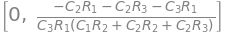

In [44]:
denom_root_sym

In [42]:
C, R = symbols('C R')
Markdown('$N_r(s)={:s}$'.format(latex(H_sym_num.subs({R1:R, R3:R, C1:C, C3:C}).collect(s).factor())))

$N_r(s)=- C R_{2} s - C_{2} R_{2} s - 1$

In a simular fashon, the denominator polynominal is:

In [43]:
Markdown('$D_r(s)={:s}$'.format(latex(H_sym_denom.subs({R1:R, R3:R, C1:C, C3:C}).collect(s).factor())))

$D_r(s)=R s \left(C^{2} R_{2} s + C C_{2} R s + C C_{2} R_{2} s + C + 2 C_{2}\right)$

You can see the $\left(CRs+1\right)$ terms will cancel in the numerator and denominator.

$\frac {N_r(s)}{D_r(s)}=\frac {- s \left(C R s + 1\right) \left(C R + C_{2} R + C_{2} R_{2}\right)}{\left(C R s + 1\right) \left(C C_{2} R R_{2} s^{2} + C_{2} R s + 1\right)}=\frac {- s \left(C R + C_{2} R + C_{2} R_{2}\right)}{ \left(C C_{2} R R_{2} s^{2} + C_{2} R s + 1\right)}$


## HFP
```
* C:\users\jeff64\My Documents\JupyterLab\Misc ipython notebooks\Buchla 295 10 Channel Comb Filter\LTSpice\HP-Twin-T-Active-Filter.asc
R1 3 0 44.2k
R2 2 5 22.1k
R3 4 3 44.2k
C1 5 1 3600p
C2 4 5 3600p
C3 2 3 1800p
XU1 4 0 2 opamp Aol=100K GBW=10Meg
V1 1 0 1 AC 1
* A Bandpass Twin-T Active Filter Used in the Buchla 200 Electric Music Box Synthesizer
* 1000 Hz band
.lib opamp.sub
.ac dec 1000 100 1000k
* R3 for each filter is a 20 kΩ potentiometer wired as a variable resistor.
* R2 for each filter consists of a fixed resistor in series with a 100 kΩ potentiometer wired as a variable resistor.
* The transfer function simplifies conveniently under the special case of R1 = R3 and C1 = C3
* .step param Rtone list 1k 2k 5k 10k
.backanno
.end
```

In [45]:
example_net_list = '''
R1 3 0 1
R2 2 5 1
R3 4 3 1
C1 5 1 1
C2 4 5 1
C3 2 3 1
O1 4 0 2
V1 1 0 1
'''

### Generate Network Equations 

In [46]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

Convert the lists of unknown node voltages and currents as well as the list of independednt voltage and current sources into SymPy matrices. 

In [47]:
X = Matrix(X)
Z = Matrix(Z)

Use the SymPy function ```Eq``` to formulate the network equations.

In [48]:
NE_sym = Eq(A*X,Z)

The equations, ```NE_sym```, define the mathematical relationship between voltages and currents in the filter circuit in terms of node voltages, $v_1$, $v_2$ etc., components $R_1$, $C_1$ etc., the Laplace variable $s$ and the indepenedent voltage source $V_1$. The equations are shown below:

In [49]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# display the equations
temp = ''
for i in range(shape(NE_sym.lhs)[0]):
    temp += '<p>${:s} = {:s}$</p>'.format(latex(NE_sym.lhs[i]),
        latex(NE_sym.rhs[i]))

Markdown(temp)

<p>$C_{1} s v_{1} - C_{1} s v_{5} + I_{V1} = 0$</p><p>$- C_{3} s v_{3} + I_{O1} + v_{2} \left(C_{3} s + \frac{1}{R_{2}}\right) - \frac{v_{5}}{R_{2}} = 0$</p><p>$- C_{3} s v_{2} + v_{3} \left(C_{3} s + \frac{1}{R_{3}} + \frac{1}{R_{1}}\right) - \frac{v_{4}}{R_{3}} = 0$</p><p>$- C_{2} s v_{5} + v_{4} \left(C_{2} s + \frac{1}{R_{3}}\right) - \frac{v_{3}}{R_{3}} = 0$</p><p>$- C_{1} s v_{1} - C_{2} s v_{4} + v_{5} \left(C_{1} s + C_{2} s + \frac{1}{R_{2}}\right) - \frac{v_{2}}{R_{2}} = 0$</p><p>$v_{1} = V_{1}$</p><p>$v_{4} = 0$</p>

The two lines of Python code below turn the free symbols from the ```NE_sym``` equations into SymPy variables and the element values contained in the netlist are put into a Python dictionary data structure to be used in the numerical solutions later in this report.

In [50]:
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

### Solve the Network Equations
The SymPy function ```solve``` is used to obtain the node voltages and independent voltage source currents.

In [51]:
U_sym = solve(NE_sym,X)

The solution to the network equations are the node voltages expressed in terms of the Laplace variable $s$ are displayed below.

In [52]:
temp = ''
for i in U_sym.keys():
    if str(i)[0] == 'v': # only display the node voltages
        temp += '<p>${:s} = {:s}$</p>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

<p>$v_{1} = V_{1}$</p><p>$v_{2} = \frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} V_{1} s^{2} - C_{1} C_{2} R_{1} R_{2} V_{1} s - C_{1} C_{2} R_{2} R_{3} V_{1} s}{C_{1} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{3} s + C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}}$</p><p>$v_{3} = - \frac{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} V_{1} s^{2}}{C_{1} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{3} s + C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}}$</p><p>$v_{4} = 0$</p><p>$v_{5} = \frac{C_{1} C_{3} R_{1} R_{2} V_{1} s}{C_{1} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{3} s + C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}}$</p>

### Voltage Transfer Function $H(s)=\frac {v_2(s)}{v_1(s)}$
The voltage transfer function, $H(s)$, for the filter  is generated and displayed by the following code:

In [53]:
H_sym = cancel(U_sym[v2]/U_sym[v1],s)
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{2} + s \left(- C_{1} C_{2} R_{1} R_{2} - C_{1} C_{2} R_{2} R_{3}\right)}{C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1} + s \left(C_{1} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right)}$

In [54]:
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

### Numerator Polynominal
The numerator polynominal is:

In [55]:
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{2} + s \left(- C_{1} C_{2} R_{1} R_{2} - C_{1} C_{2} R_{2} R_{3}\right)$

The coeficients of each Laplace terms can be equated to the variables $b_2$, $b_1$ and $b_0$ in the expression: 

$b_2s^{2}+b_1s+b_0$

where $b_2$, $b_1$ and $b_0$ are:

In [56]:
b2 = H_sym_num.coeff(s**2)
b1 = H_sym_num.coeff(s**1)
b0 = H_sym_num - b1*s*1 - b2*s**2

Markdown('<p>$b_2={:s}$</p><p>$b_1={:s}$</p><p>$b_0={:s}$</p>'.format(latex(b2),latex(b1),latex(b0)))

<p>$b_2=- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3}$</p><p>$b_1=- C_{1} C_{2} R_{1} R_{2} - C_{1} C_{2} R_{2} R_{3}$</p><p>$b_0=0$</p>

Notice that ther terms $b_2$ and $b_1$ are negative. This follows from the Op Amp being configured as an inverting amplifier. R2 and R3 provide a DC path from the Op Amp's output to the inverting terminal.

The roots of the numerator polynominal can easily be found with SymPy. 

This filter has two transmission zeros

In [57]:
num_root_sym = solve(H_sym_num,s)

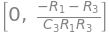

In [59]:
num_root_sym

There are two solutions, $z_1=0$ and another root at: 

In [58]:
Markdown('$z_2={:s}$'.format(latex(num_root_sym[1])))

$z_2=\frac{- R_{1} - R_{3}}{C_{3} R_{1} R_{3}}$

### Denominator Polynominal
The demoninator polynominal of the transfer function is called the characteristic polynominal. The roots of the denominator, also called poles of the system,  determine the system's stability. If any of these roots have a positive real part, the system is unstable, meaning its output will grow unbounded. The roots also influence how the system responds to changes in input (the transient response). They affect things like how quickly the system settles to a new state, whether it oscillates, and the damping of those oscillations. Each root of the characteristic polynominal corresponds to a natural mode of the system.

The denominator polynominal is:

In [60]:
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1} + s \left(C_{1} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right)$

The coeficients of each Laplace terms can be equated to the variables $a_3$, $a_2$, $a_1$ and $a_0$ in the expression: 

$a_3s^3+a_2s^2+a_1s+a_0$

where $a_3$, $a_2$, $a_1$ and $a_0$ are:

In [61]:
a3 = H_sym_denom.coeff(s**3)
a2 = H_sym_denom.coeff(s**2)
a1 = H_sym_denom.coeff(s**1)
a0 = H_sym_denom - a1*s*1 - a2*s**2 - a3*s**3
Markdown('<p>$a_3={:s}$</p><p>$a_2={:s}$</p><p>$a_1={:s}$</p><p>$a_0={:s}$</p>'.format(latex(a3), latex(a2),latex(a1),latex(a0)))

<p>$a_3=0$</p><p>$a_2=0$</p><p>$a_1=C_{1} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}$</p><p>$a_0=C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}$</p>

The roots of the denominator polynominal can found with SymPy. The filter circuit being analyzed in this report has a denominator polynominal that SymPy can quickly solve. This is not always the case. The expressions are long and do not render well when the JupyterLab notebook is converted to PDF, so the expressions were converted to LaTex strings and then to PNG images with [latex2png](https://latex2png.com/) for this report.

In [62]:
denom_root_sym = solve(H_sym_denom,s)

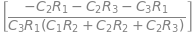

In [65]:
denom_root_sym

In [63]:
C, R = symbols('C R')
Markdown('$N_r(s)={:s}$'.format(latex(H_sym_num.subs({R1:R, R3:R, C1:C, C3:C}).collect(s).factor())))

$N_r(s)=- C C_{2} R R_{2} s \left(C R s + 2\right)$

In a simular fashon, the denominator polynominal is:

In [64]:
Markdown('$D_r(s)={:s}$'.format(latex(H_sym_denom.subs({R1:R, R3:R, C1:C, C3:C}).collect(s).factor())))

$D_r(s)=R \left(C^{2} R_{2} s + C C_{2} R s + C C_{2} R_{2} s + C + 2 C_{2}\right)$

You can see the $\left(CRs+1\right)$ terms will cancel in the numerator and denominator.

$\frac {N_r(s)}{D_r(s)}=\frac {- s \left(C R s + 1\right) \left(C R + C_{2} R + C_{2} R_{2}\right)}{\left(C R s + 1\right) \left(C C_{2} R R_{2} s^{2} + C_{2} R s + 1\right)}=\frac {- s \left(C R + C_{2} R + C_{2} R_{2}\right)}{ \left(C C_{2} R R_{2} s^{2} + C_{2} R s + 1\right)}$


## BR
```
* C:\users\jeff64\My Documents\JupyterLab\Misc ipython notebooks\Buchla 295 10 Channel Comb Filter\LTSpice\BR-Twin-T-Active-Filter.asc
R1 3 1 15k
R2 4 3 186k
R3 2 5 15k
C1 5 1 10n
C2 4 5 910p
C3 2 3 10n
XU1 4 0 2 opamp Aol=100K GBW=10Meg
V1 1 0 1 AC 1
* A Bandpass Twin-T Active Filter Used in the Buchla 200 Electric Music Box Synthesizer
* 1000 Hz band
.lib opamp.sub
.ac dec 1000 100 10k
* R3 for each filter is a 20 kΩ potentiometer wired as a variable resistor.
* R2 for each filter consists of a fixed resistor in series with a 100 kΩ potentiometer wired as a variable resistor.
* The transfer function simplifies conveniently under the special case of R1 = R3 and C1 = C3
* .step param Rtone list 1k 2k 5k 10k
.backanno
.end
```

In [66]:
example_net_list = '''
R1 3 1 1
R2 4 3 1
R3 2 5 1
C1 5 1 1
C2 4 5 1
C3 2 3 1
O1 4 0 2
V1 1 0 1
'''

### Generate Network Equations 

In [67]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

Convert the lists of unknown node voltages and currents as well as the list of independednt voltage and current sources into SymPy matrices. 

In [68]:
X = Matrix(X)
Z = Matrix(Z)

Use the SymPy function ```Eq``` to formulate the network equations.

In [69]:
NE_sym = Eq(A*X,Z)

The equations, ```NE_sym```, define the mathematical relationship between voltages and currents in the filter circuit in terms of node voltages, $v_1$, $v_2$ etc., components $R_1$, $C_1$ etc., the Laplace variable $s$ and the indepenedent voltage source $V_1$. The equations are shown below:

In [70]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# display the equations
temp = ''
for i in range(shape(NE_sym.lhs)[0]):
    temp += '<p>${:s} = {:s}$</p>'.format(latex(NE_sym.lhs[i]),
        latex(NE_sym.rhs[i]))

Markdown(temp)

<p>$- C_{1} s v_{5} + I_{V1} + v_{1} \left(C_{1} s + \frac{1}{R_{1}}\right) - \frac{v_{3}}{R_{1}} = 0$</p><p>$- C_{3} s v_{3} + I_{O1} + v_{2} \left(C_{3} s + \frac{1}{R_{3}}\right) - \frac{v_{5}}{R_{3}} = 0$</p><p>$- C_{3} s v_{2} + v_{3} \left(C_{3} s + \frac{1}{R_{2}} + \frac{1}{R_{1}}\right) - \frac{v_{4}}{R_{2}} - \frac{v_{1}}{R_{1}} = 0$</p><p>$- C_{2} s v_{5} + v_{4} \left(C_{2} s + \frac{1}{R_{2}}\right) - \frac{v_{3}}{R_{2}} = 0$</p><p>$- C_{1} s v_{1} - C_{2} s v_{4} + v_{5} \left(C_{1} s + C_{2} s + \frac{1}{R_{3}}\right) - \frac{v_{2}}{R_{3}} = 0$</p><p>$v_{1} = V_{1}$</p><p>$v_{4} = 0$</p>

The two lines of Python code below turn the free symbols from the ```NE_sym``` equations into SymPy variables and the element values contained in the netlist are put into a Python dictionary data structure to be used in the numerical solutions later in this report.

In [71]:
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

### Solve the Network Equations
The SymPy function ```solve``` is used to obtain the node voltages and independent voltage source currents.

In [72]:
U_sym = solve(NE_sym,X)

The solution to the network equations are the node voltages expressed in terms of the Laplace variable $s$ are displayed below.

In [73]:
temp = ''
for i in U_sym.keys():
    if str(i)[0] == 'v': # only display the node voltages
        temp += '<p>${:s} = {:s}$</p>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

<p>$v_{1} = V_{1}$</p><p>$v_{2} = \frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} V_{1} s^{3} - C_{1} C_{2} R_{1} R_{3} V_{1} s^{2} - C_{1} C_{2} R_{2} R_{3} V_{1} s^{2} - C_{1} R_{3} V_{1} s - C_{2} R_{3} V_{1} s - V_{1}}{C_{1} C_{3} R_{1} R_{3} s^{2} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{2} R_{2} s + C_{3} R_{1} s}$</p><p>$v_{3} = \frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} V_{1} s^{2} + C_{2} R_{2} V_{1}}{C_{1} C_{3} R_{1} R_{3} s + C_{2} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{3} s + C_{2} R_{1} + C_{2} R_{2} + C_{3} R_{1}}$</p><p>$v_{4} = 0$</p><p>$v_{5} = \frac{C_{1} C_{3} R_{1} R_{3} V_{1} s^{2} - V_{1}}{C_{1} C_{3} R_{1} R_{3} s^{2} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{2} R_{2} s + C_{3} R_{1} s}$</p>

### Voltage Transfer Function $H(s)=\frac {v_2(s)}{v_1(s)}$
The voltage transfer function, $H(s)$, for the filter  is generated and displayed by the following code:

In [74]:
H_sym = cancel(U_sym[v2]/U_sym[v1],s)
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + s^{2} \left(- C_{1} C_{2} R_{1} R_{3} - C_{1} C_{2} R_{2} R_{3}\right) + s \left(- C_{1} R_{3} - C_{2} R_{3}\right) - 1}{s^{2} \left(C_{1} C_{3} R_{1} R_{3} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right) + s \left(C_{2} R_{1} + C_{2} R_{2} + C_{3} R_{1}\right)}$

In [75]:
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

### Numerator Polynominal
The numerator polynominal is:

In [76]:
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + s^{2} \left(- C_{1} C_{2} R_{1} R_{3} - C_{1} C_{2} R_{2} R_{3}\right) + s \left(- C_{1} R_{3} - C_{2} R_{3}\right) - 1$

The coeficients of each Laplace terms can be equated to the variables $b_2$, $b_1$ and $b_0$ in the expression: 

$b_2s^{2}+b_1s+b_0$

where $b_2$, $b_1$ and $b_0$ are:

In [77]:
b2 = H_sym_num.coeff(s**2)
b1 = H_sym_num.coeff(s**1)
b0 = H_sym_num - b1*s*1 - b2*s**2

Markdown('<p>$b_2={:s}$</p><p>$b_1={:s}$</p><p>$b_0={:s}$</p>'.format(latex(b2),latex(b1),latex(b0)))

<p>$b_2=- C_{1} C_{2} R_{1} R_{3} - C_{1} C_{2} R_{2} R_{3}$</p><p>$b_1=- C_{1} R_{3} - C_{2} R_{3}$</p><p>$b_0=- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} - 1$</p>

Notice that ther terms $b_2$ and $b_1$ are negative. This follows from the Op Amp being configured as an inverting amplifier. R2 and R3 provide a DC path from the Op Amp's output to the inverting terminal.

The roots of the numerator polynominal can easily be found with SymPy. 

This filter has two transmission zeros

In [78]:
num_root_sym = solve(H_sym_num,s)

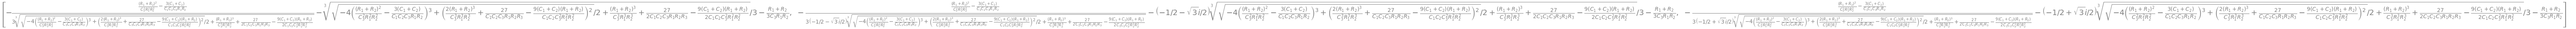

In [79]:
num_root_sym

### Denominator Polynominal
The demoninator polynominal of the transfer function is called the characteristic polynominal. The roots of the denominator, also called poles of the system,  determine the system's stability. If any of these roots have a positive real part, the system is unstable, meaning its output will grow unbounded. The roots also influence how the system responds to changes in input (the transient response). They affect things like how quickly the system settles to a new state, whether it oscillates, and the damping of those oscillations. Each root of the characteristic polynominal corresponds to a natural mode of the system.

The denominator polynominal is:

In [80]:
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=s^{2} \left(C_{1} C_{3} R_{1} R_{3} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right) + s \left(C_{2} R_{1} + C_{2} R_{2} + C_{3} R_{1}\right)$

The coeficients of each Laplace terms can be equated to the variables $a_3$, $a_2$, $a_1$ and $a_0$ in the expression: 

$a_3s^3+a_2s^2+a_1s+a_0$

where $a_3$, $a_2$, $a_1$ and $a_0$ are:

In [81]:
a3 = H_sym_denom.coeff(s**3)
a2 = H_sym_denom.coeff(s**2)
a1 = H_sym_denom.coeff(s**1)
a0 = H_sym_denom - a1*s*1 - a2*s**2 - a3*s**3
Markdown('<p>$a_3={:s}$</p><p>$a_2={:s}$</p><p>$a_1={:s}$</p><p>$a_0={:s}$</p>'.format(latex(a3), latex(a2),latex(a1),latex(a0)))

<p>$a_3=0$</p><p>$a_2=C_{1} C_{3} R_{1} R_{3} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}$</p><p>$a_1=C_{2} R_{1} + C_{2} R_{2} + C_{3} R_{1}$</p><p>$a_0=0$</p>

The roots of the denominator polynominal can found with SymPy. The filter circuit being analyzed in this report has a denominator polynominal that SymPy can quickly solve. This is not always the case. The expressions are long and do not render well when the JupyterLab notebook is converted to PDF, so the expressions were converted to LaTex strings and then to PNG images with [latex2png](https://latex2png.com/) for this report.

In [82]:
denom_root_sym = solve(H_sym_denom,s)

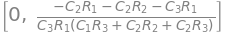

In [83]:
denom_root_sym

In [84]:
C, R = symbols('C R')
Markdown('$N_r(s)={:s}$'.format(latex(H_sym_num.subs({R1:R, R3:R, C1:C, C3:C}).collect(s).factor())))

$N_r(s)=- \left(C R s + 1\right) \left(C C_{2} R R_{2} s^{2} + C_{2} R s + 1\right)$

In a simular fashon, the denominator polynominal is:

In [85]:
Markdown('$D_r(s)={:s}$'.format(latex(H_sym_denom.subs({R1:R, R3:R, C1:C, C3:C}).collect(s).factor())))

$D_r(s)=s \left(C R s + 1\right) \left(C R + C_{2} R + C_{2} R_{2}\right)$

You can see the $\left(CRs+1\right)$ terms will cancel in the numerator and denominator.

$\frac {N_r(s)}{D_r(s)}=\frac {- s \left(C R s + 1\right) \left(C R + C_{2} R + C_{2} R_{2}\right)}{\left(C R s + 1\right) \left(C C_{2} R R_{2} s^{2} + C_{2} R s + 1\right)}=\frac {- s \left(C R + C_{2} R + C_{2} R_{2}\right)}{ \left(C C_{2} R R_{2} s^{2} + C_{2} R s + 1\right)}$


# BPF

In [2]:
example_net_list = '''
* Bandpass-Twin-T-Active-Filter.asc
R1 3 1 15e3
R2 4 5 186e3
R3 2 5 15e3
C1 5 1 10e-9
C2 4 3 910e-12
C3 2 3 10e-9
O1 4 0 2
V1 1 0 1
'''

### Generate Network Equations 

In [3]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

Convert the lists of unknown node voltages and currents as well as the list of independednt voltage and current sources into SymPy matrices. 

In [4]:
X = Matrix(X)
Z = Matrix(Z)

Use the SymPy function ```Eq``` to formulate the network equations.

In [5]:
NE_sym = Eq(A*X,Z)

The equations, ```NE_sym```, define the mathematical relationship between voltages and currents in the filter circuit in terms of node voltages, $v_1$, $v_2$ etc., components $R_1$, $C_1$ etc., the Laplace variable $s$ and the indepenedent voltage source $V_1$. The equations are shown below:

In [6]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# display the equations
temp = ''
for i in range(shape(NE_sym.lhs)[0]):
    temp += '<p>${:s} = {:s}$</p>'.format(latex(NE_sym.lhs[i]),
        latex(NE_sym.rhs[i]))

Markdown(temp)

<p>$- C_{1} s v_{5} + I_{V1} + v_{1} \left(C_{1} s + \frac{1}{R_{1}}\right) - \frac{v_{3}}{R_{1}} = 0$</p><p>$- C_{3} s v_{3} + I_{O1} + v_{2} \left(C_{3} s + \frac{1}{R_{3}}\right) - \frac{v_{5}}{R_{3}} = 0$</p><p>$- C_{2} s v_{4} - C_{3} s v_{2} + v_{3} \left(C_{2} s + C_{3} s + \frac{1}{R_{1}}\right) - \frac{v_{1}}{R_{1}} = 0$</p><p>$- C_{2} s v_{3} + v_{4} \left(C_{2} s + \frac{1}{R_{2}}\right) - \frac{v_{5}}{R_{2}} = 0$</p><p>$- C_{1} s v_{1} + v_{5} \left(C_{1} s + \frac{1}{R_{3}} + \frac{1}{R_{2}}\right) - \frac{v_{2}}{R_{3}} - \frac{v_{4}}{R_{2}} = 0$</p><p>$v_{1} = V_{1}$</p><p>$v_{4} = 0$</p>

The two lines of Python code below turn the free symbols from the ```NE_sym``` equations into SymPy variables and the element values contained in the netlist are put into a Python dictionary data structure to be used in the numerical solutions later in this report.

In [7]:
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

### Solve the Network Equations
The SymPy function ```solve``` is used to obtain the node voltages and independent voltage source currents.

In [8]:
U_sym = solve(NE_sym,X)

The solution to the network equations are the node voltages expressed in terms of the Laplace variable $s$ are displayed below.

In [9]:
temp = ''
for i in U_sym.keys():
    if str(i)[0] == 'v': # only display the node voltages
        temp += '<p>${:s} = {:s}$</p>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

<p>$v_{1} = V_{1}$</p><p>$v_{2} = \frac{- C_{1} C_{2} R_{1} R_{3} V_{1} s^{2} - C_{1} C_{2} R_{2} R_{3} V_{1} s^{2} - C_{1} C_{3} R_{1} R_{3} V_{1} s^{2} - C_{1} R_{3} V_{1} s - C_{2} R_{2} V_{1} s - C_{2} R_{3} V_{1} s}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{3} R_{1} s + 1}$</p><p>$v_{3} = \frac{- C_{1} C_{3} R_{1} R_{3} V_{1} s^{2} + V_{1}}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{3} R_{1} s + 1}$</p><p>$v_{4} = 0$</p><p>$v_{5} = \frac{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} V_{1} s^{3} - C_{2} R_{2} V_{1} s}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{3} R_{1} s + 1}$</p>

### Voltage Transfer Function $H(s)=\frac {v_2(s)}{v_1(s)}$
The voltage transfer function, $H(s)$, for the filter  is generated and displayed by the following code:

In [10]:
H_sym = cancel(U_sym[v2]/U_sym[v1],s)
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{s^{2} \left(- C_{1} C_{2} R_{1} R_{3} - C_{1} C_{2} R_{2} R_{3} - C_{1} C_{3} R_{1} R_{3}\right) + s \left(- C_{1} R_{3} - C_{2} R_{2} - C_{2} R_{3}\right)}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + s^{2} \left(C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right) + s \left(C_{2} R_{1} + C_{3} R_{1}\right) + 1}$

In [13]:
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

### Numerator Polynominal
The numerator polynominal is:

In [14]:
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=s^{2} \left(- C_{1} C_{2} R_{1} R_{3} - C_{1} C_{2} R_{2} R_{3} - C_{1} C_{3} R_{1} R_{3}\right) + s \left(- C_{1} R_{3} - C_{2} R_{2} - C_{2} R_{3}\right)$

The coeficients of each Laplace terms can be equated to the variables $b_2$, $b_1$ and $b_0$ in the expression: 

$b_2s^{2}+b_1s+b_0$

where $b_2$, $b_1$ and $b_0$ are:

In [15]:
b2 = H_sym_num.coeff(s**2)
b1 = H_sym_num.coeff(s**1)
b0 = H_sym_num - b1*s*1 - b2*s**2

Markdown('<p>$b_2={:s}$</p><p>$b_1={:s}$</p><p>$b_0={:s}$</p>'.format(latex(b2),latex(b1),latex(b0)))

<p>$b_2=- C_{1} C_{2} R_{1} R_{3} - C_{1} C_{2} R_{2} R_{3} - C_{1} C_{3} R_{1} R_{3}$</p><p>$b_1=- C_{1} R_{3} - C_{2} R_{2} - C_{2} R_{3}$</p><p>$b_0=0$</p>

Notice that ther terms $b_2$ and $b_1$ are negative. This follows from the Op Amp being configured as an inverting amplifier. R2 and R3 provide a DC path from the Op Amp's output to the inverting terminal.

The roots of the numerator polynominal can easily be found with SymPy. 

This filter has two transmission zeros

In [16]:
num_root_sym = solve(H_sym_num,s)

There are two solutions, $z_1=0$ and another root at: 

In [17]:
Markdown('$z_2={:s}$'.format(latex(num_root_sym[1])))

$z_2=\frac{- C_{1} R_{3} - C_{2} R_{2} - C_{2} R_{3}}{C_{1} R_{3} \left(C_{2} R_{1} + C_{2} R_{2} + C_{3} R_{1}\right)}$

### Denominator Polynominal
The demoninator polynominal of the transfer function is called the characteristic polynominal. The roots of the denominator, also called poles of the system,  determine the system's stability. If any of these roots have a positive real part, the system is unstable, meaning its output will grow unbounded. The roots also influence how the system responds to changes in input (the transient response). They affect things like how quickly the system settles to a new state, whether it oscillates, and the damping of those oscillations. Each root of the characteristic polynominal corresponds to a natural mode of the system.

The denominator polynominal is:

In [18]:
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + s^{2} \left(C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right) + s \left(C_{2} R_{1} + C_{3} R_{1}\right) + 1$

The coeficients of each Laplace terms can be equated to the variables $a_3$, $a_2$, $a_1$ and $a_0$ in the expression: 

$a_3s^3+a_2s^2+a_1s+a_0$

where $a_3$, $a_2$, $a_1$ and $a_0$ are:

In [19]:
a3 = H_sym_denom.coeff(s**3)
a2 = H_sym_denom.coeff(s**2)
a1 = H_sym_denom.coeff(s**1)
a0 = H_sym_denom - a1*s*1 - a2*s**2 - a3*s**3
Markdown('<p>$a_3={:s}$</p><p>$a_2={:s}$</p><p>$a_1={:s}$</p><p>$a_0={:s}$</p>'.format(latex(a3), latex(a2),latex(a1),latex(a0)))

<p>$a_3=C_{1} C_{2} C_{3} R_{1} R_{2} R_{3}$</p><p>$a_2=C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}$</p><p>$a_1=C_{2} R_{1} + C_{3} R_{1}$</p><p>$a_0=1$</p>

The roots of the denominator polynominal can found with SymPy. The filter circuit being analyzed in this report has a denominator polynominal that SymPy can quickly solve. This is not always the case. The expressions are long and do not render well when the JupyterLab notebook is converted to PDF, so the expressions were converted to LaTex strings and then to PNG images with [latex2png](https://latex2png.com/) for this report.

In [20]:
denom_root_sym = solve(H_sym_denom,s)

In [21]:
C, R = symbols('C R')
Markdown('$N_r(s)={:s}$'.format(latex(H_sym_num.subs({R1:R, R3:R, C1:C, C3:C}).collect(s).factor())))

$N_r(s)=- s \left(C R s + 1\right) \left(C R + C_{2} R + C_{2} R_{2}\right)$

In a simular fashon, the denominator polynominal is:

In [22]:
Markdown('$D_r(s)={:s}$'.format(latex(H_sym_denom.subs({R1:R, R3:R, C1:C, C3:C}).collect(s).factor())))

$D_r(s)=\left(C R s + 1\right) \left(C C_{2} R R_{2} s^{2} + C_{2} R s + 1\right)$

You can see the $\left(CRs+1\right)$ terms will cancel in the numerator and denominator.

$\frac {N_r(s)}{D_r(s)}=\frac {- s \left(C R s + 1\right) \left(C R + C_{2} R + C_{2} R_{2}\right)}{\left(C R s + 1\right) \left(C C_{2} R R_{2} s^{2} + C_{2} R s + 1\right)}=\frac {- s \left(C R + C_{2} R + C_{2} R_{2}\right)}{ \left(C C_{2} R R_{2} s^{2} + C_{2} R s + 1\right)}$
